In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/car-price-prediction-challenge/car_price_prediction.csv


In [2]:
#loading data as datafram file
df = pd.read_csv('/kaggle/input/car-price-prediction-challenge/car_price_prediction.csv')

In [3]:
df.head()

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4


In [4]:
df.describe()

,ID,Price,Prod. year,Cylinders,Airbags
count,1.923700e+04,1.923700e+04,19237.000000,19237.000000,19237.000000
mean,4.557654e+07,1.855593e+04,2010.912824,4.582991,6.582627
std,9.365914e+05,1.905813e+05,5.668673,1.199933,4.320168
min,2.074688e+07,1.000000e+00,1939.000000,1.000000,0.000000
25%,4.569837e+07,5.331000e+03,2009.000000,4.000000,4.000000
50%,4.577231e+07,1.317200e+04,2012.000000,4.000000,6.000000
75%,4.580204e+07,2.207500e+04,2015.000000,4.000000,12.000000
max,4.581665e+07,2.630750e+07,2020.000000,16.000000,16.000000


In [5]:
def basic_stats(col):
    return df[col].mean(), df[col].std(), df[col].median(), df[col].max(), df[col].min()

print(basic_stats('Price'))

(18555.92722357956, 190581.26968400914, 13172.0, 26307500, 1)


In [6]:
df[df['Price']>=200000]

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
1225,45795524,627220,-,MERCEDES-BENZ,G 65 AMG 63AMG,2020,Jeep,Yes,Petrol,6.3 Turbo,0 km,8.0,Tiptronic,4x4,04-May,Left wheel,Black,12
2283,45786808,219527,-,BENTLEY,Continental GT,2012,Coupe,Yes,Petrol,4.0 Turbo,55500 km,8.0,Tiptronic,4x4,02-Mar,Left wheel,Black,0
5008,45810285,308906,1694,PORSCHE,911,2016,Coupe,Yes,Petrol,4,8690 km,6.0,Automatic,Rear,02-Mar,Left wheel,Black,12
5840,44991441,254024,1292,MERCEDES-BENZ,GLE 400 A M G,2016,Jeep,Yes,Petrol,3.0 Turbo,73000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,12
7283,45420737,228935,-,MERCEDES-BENZ,GLE 63 AMG,2018,Jeep,Yes,Petrol,5.5 Turbo,23000 km,8.0,Tiptronic,4x4,04-May,Left wheel,Black,16
7353,43683199,216391,-,MERCEDES-BENZ,G 65 AMG G63 AMG,2013,Jeep,Yes,Petrol,5.5 Turbo,54000 km,8.0,Tiptronic,4x4,04-May,Left wheel,Black,12
7749,45760644,288521,2269,BMW,M5 Машина в максимально,2018,Sedan,Yes,Petrol,4.4,13500 km,8.0,Tiptronic,4x4,04-May,Left wheel,Black,0
8541,45761204,872946,2067,LAMBORGHINI,Urus,2019,Universal,Yes,Petrol,4,2531 km,8.0,Tiptronic,4x4,04-May,Left wheel,Black,0
9367,45229113,297930,-,MERCEDES-BENZ,AMG GT S,2015,Coupe,Yes,Petrol,4.0 Turbo,20000 km,8.0,Tiptronic,Rear,02-Mar,Left wheel,White,16
10759,45291161,260296,-,LEXUS,LX 570,2018,Jeep,Yes,Petrol,5.7 Turbo,17700 km,8.0,Tiptronic,4x4,04-May,Left wheel,Black,10


In [7]:
df = df[df['ID']!=45812886]

In [8]:
int_cols = df.dtypes[df.dtypes == 'int64'].index
flot_cols = df.dtypes[df.dtypes == 'float64'].index

for col in int_cols:
    print(col, basic_stats(col))
    
for col in flot_cols:
    print(col, basic_stats(col))
    

ID (45576523.599241, 936614.2180781392, 45772307.0, 45816654, 20746880)
Price (17189.273861509668, 19786.33778773476, 13172.0, 872946, 1)
Prod. year (2010.9134435433562, 5.668169523745634, 2012.0, 2020, 1939)
Airbags (6.58296943231441, 4.320019957701316, 6.0, 16, 0)
Cylinders (4.583021418174257, 1.1999569959189724, 4.0, 16.0, 1.0)


<AxesSubplot:xlabel='Manufacturer', ylabel='Price'>

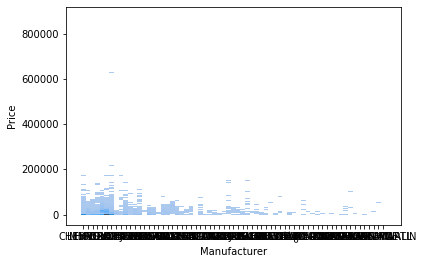

In [9]:
sns.histplot(data=df,x='Manufacturer',y="Price")

<AxesSubplot:xlabel='Manufacturer', ylabel='Price'>

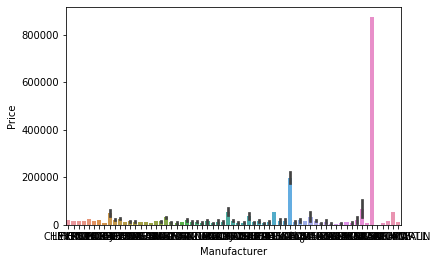

In [10]:
sns.barplot(data=df,x='Manufacturer',y="Price")

In [11]:
df_price = df.groupby(by=['Manufacturer'])['Price'].mean()

In [12]:
df_price.index

Index(['ACURA', 'ALFA ROMEO', 'ASTON MARTIN', 'AUDI', 'BENTLEY', 'BMW',
       'BUICK', 'CADILLAC', 'CHEVROLET', 'CHRYSLER', 'CITROEN', 'DAEWOO',
       'DAIHATSU', 'DODGE', 'FERRARI', 'FIAT', 'FORD', 'GAZ', 'GMC',
       'GREATWALL', 'HAVAL', 'HONDA', 'HUMMER', 'HYUNDAI', 'INFINITI', 'ISUZU',
       'JAGUAR', 'JEEP', 'KIA', 'LAMBORGHINI', 'LANCIA', 'LAND ROVER', 'LEXUS',
       'LINCOLN', 'MASERATI', 'MAZDA', 'MERCEDES-BENZ', 'MERCURY', 'MINI',
       'MITSUBISHI', 'MOSKVICH', 'NISSAN', 'OPEL', 'PEUGEOT', 'PONTIAC',
       'PORSCHE', 'RENAULT', 'ROLLS-ROYCE', 'ROVER', 'SAAB', 'SATURN', 'SCION',
       'SEAT', 'SKODA', 'SSANGYONG', 'SUBARU', 'SUZUKI', 'TESLA', 'TOYOTA',
       'UAZ', 'VAZ', 'VOLKSWAGEN', 'VOLVO', 'ZAZ', 'სხვა'],
      dtype='object', name='Manufacturer')

In [13]:
df[df['Manufacturer']=="LAMBORGHINI"]

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
8541,45761204,872946,2067,LAMBORGHINI,Urus,2019,Universal,Yes,Petrol,4,2531 km,8.0,Tiptronic,4x4,04-May,Left wheel,Black,0


In [14]:
px.bar(x=df_price.index,y=df_price.values)

In [15]:
df_n = df[df['Manufacturer']!="LAMBORGHINI"]

In [16]:
df_price_n = df_n.groupby(by=['Manufacturer'])['Price'].mean()

In [17]:
px.bar(x=df_price_n.index,y=df_price_n.values)

In [18]:
df['Manufacturer'].value_counts()[df['Manufacturer'].value_counts() <= 10].index, len(df['Manufacturer'].value_counts()[df['Manufacturer'].value_counts() <= 10].index)

(Index(['CITROEN', 'SCION', 'HUMMER', 'MASERATI', 'MERCURY', 'ISUZU',
        'ALFA ROMEO', 'MOSKVICH', 'ROVER', 'FERRARI', 'SAAB', 'ROLLS-ROYCE',
        'სხვა', 'SEAT', 'ZAZ', 'BENTLEY', 'LANCIA', 'HAVAL', 'LAMBORGHINI',
        'TESLA', 'PONTIAC', 'SATURN', 'ASTON MARTIN', 'GREATWALL'],
       dtype='object'),
 24)

As we can see there are 24 Manufacturers with less than 10 listings that skew our charts

In [19]:
less_than_10 = list(df['Manufacturer'].value_counts()[df['Manufacturer'].value_counts() <= 10].index)

In [20]:
list(less_than_10)

['CITROEN',
 'SCION',
 'HUMMER',
 'MASERATI',
 'MERCURY',
 'ISUZU',
 'ALFA ROMEO',
 'MOSKVICH',
 'ROVER',
 'FERRARI',
 'SAAB',
 'ROLLS-ROYCE',
 'სხვა',
 'SEAT',
 'ZAZ',
 'BENTLEY',
 'LANCIA',
 'HAVAL',
 'LAMBORGHINI',
 'TESLA',
 'PONTIAC',
 'SATURN',
 'ASTON MARTIN',
 'GREATWALL']

In [21]:
df_more_than_10 = df[~df['Manufacturer'].isin(less_than_10)]

In [22]:
df_price_more_than_10 = df_more_than_10.groupby(by=['Manufacturer'])['Price'].mean()

In [23]:
px.bar(x=df_price_more_than_10.index,
       y=df_price_more_than_10.values,
       title="Mean car manufacture price",
       template="simple_white",
      labels={"x":"Manufacturer","y":"mean price"})


Compared to previous charts no large outliers change the overall view of the chart

## First Inspection

as we can see from the above descriptions and overviews the dataset consists of 18 columns.
- 13 are Strings
- 5 are Numeric (4 Int, 1 float)